# <span style="color:green"><center> Más sobre árboles: árboles de clasificación, Bagging, Random Forest, XGBoosting </center></span>

**Fernando Moreno, Frank Pedraza**

11 de noviembre 2022

## Introducción

La idea principal de los métodos estadísticos basados en árboles es segmentar el espacio de predictores en múltiples subregiones, cada una de las cuales contiene observaciones relativamente más homogéneas, con el fin que modelos más simples puedan ser usados en esas subregiones.

Debido a que muchas de la investigaciones de los métodos basados en árboles asumen que los datos son independientes, se requieren algunas modificaciones para tener en cuenta la estructura de dependencia en el contexto de series de tiempo y también algunas precauciones al implementar estos métodos.

## Árboles de clasificación

Son un caso particular de los árboles de decisión, en el cual la variable respuesta es categórica, debido a la naturaleza de la variable respuesta se requiere una función objetivo diferente a la del árbol de regresión: $ SSE_1 (c) = \sum_{t \in R1} (y_t - \bar{y}_{1,c})^2 + \sum_{t \in R2} (y_t - \bar{y}_{2,c})^2 $. Entonces, suponga que la variable respuesta $y_t$ puede tomar $K$ valores posibles, sean $\boldsymbol{x}_t$ el vector de variables explicativas, y $R_i$ la $i$-ésima hoja (o región) del árbol, se puede estimar la probabilidad de que $y_t$ pertenezca a la categoria $k$ en $R_i$ de la siguiente forma: 
$$ \hat{p}_{ik} = \frac{|R_{ik}|}{|R_i|}, \ k \ = \ 1, \ldots, K  $$

donde $R_{ik} = \{ j | (y_j = k) \ \cap \ (\boldsymbol{x}_j \in R_i) \}$ en el conjunto de netrenamiento, y $|R_i|$ es el número de observaciones en $R_i$

Para predicción se considera usar la regla simple de la mayotia, conocida como la clase que ocurre más frecuentemente, así dado $\boldsymbol{x}_t \in R_i$ se tiene:
$$ \hat{y} = K_0 , \ k_0 = {argmax}_k (\hat{p}_{ik})$$
El error de clasificación resultante para $y_t$ es: $p_t = 1 - \hat{p}_{i, k_0}$, experiencias previas muestran que esta métrica no es lo suficientemente sensible para hacer crecer un árbol de decisión, por lo que surgen dos medidas alternativas:
   + Gini index $$ g_t = \sum_{k = 1}^K \hat{p}_{ik} (1-\hat{p}_{ik}) = 1 - \sum_{k = 1}^K \hat{p}_{ik}^2 \hspace{2cm} (1)$$ 
   + Cross-entropy $$ - \sum_{k = 1}^K \hat{p}_{ik} log(\hat{p}_{ik}) \hspace{2cm} (2)$$

En la práctica el *Gini index* es más rápida de obtener que *Cross-entropy*, además entre sus características el *Gini index* tiende a aislar las clases más frecuentes en su propia rama del árbol, por otra parte una de las características de *Cross-entropy* es que tiende a producir árboles ligeramente más balanceados, 

## Bagging (Bootstrap Aggregation)

Es un método que surge a partir de la idea de reducir la varianza del modelo estadístico, en la implementación se requiere tomar muchas muestras bootstrap (con reemplazo) del conjunto de entrenamiento y usar cada una de estas muestras para obtener un árbol de decisión.
Cuando las muestras son sin reemplazo el método se denomina *pasting*.

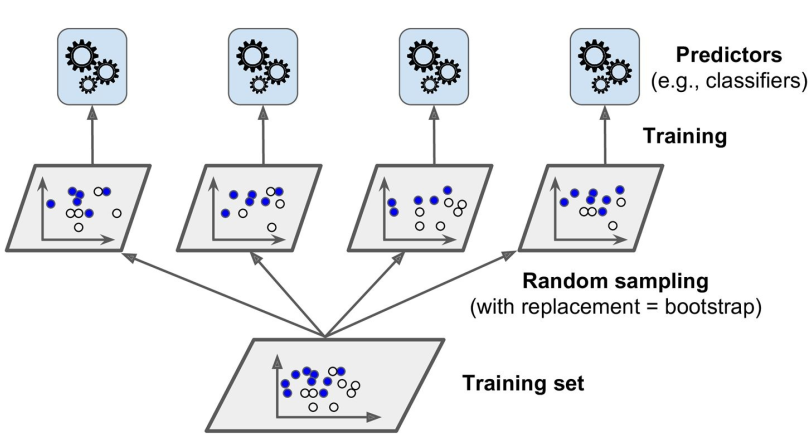

Bagging conjuntos de entrenamiento muestreados \
Tomada de Géron, A. (2017)

+ En el escenario de predicción, se considere a $\hat{y}_{n+1,m}$ la predicción obtenida de la $m$-ésima muestra bootstrap, donce $m = 1 , \ldots, M$, con $M$ un entero suficientemente grande, con lo cual la predicción bagged es:
$$ \hat{y}_{n+1,bag} = \frac{1}{M} \sum_{m = 1}^{M} \hat{y}_{n+1,m} $$ para los árboles de clasificación se puede reemplazar el promedio muestral por la *mayoria de votos* de las $M$ predicciones bootstrap para alcanzar el efecto Bagging.

+ Los árboles de decisión de las muestras bootstrap en la práctica no consideran un proceso de regularización, es decir crecen profundo y no son podados, bajo la idea de mantener el sesgo lo más pequeño posible en cada árbol.

+ En el contexto de datos de series de tiempo, se requiere aplicar métodos bootstrap más adecuados, en la literatura se mencionan métodos como: *block bootsrap, wild bootstrap,* y *frequency domain bootstrap*. A continuación se amplian detalles del método más referenciado en la literatura:
    + **block bootstrap**: en este método secciones contiguas de la serie de tiempo se seleccionan aleatoriamente y se unen conjuntamente, entre los más usados de esta familia están: non-overlapping block bootstrap (NBB), moving block bootstrap (MBB), circular block bootstrap (CBB), and stationary bootstrap (SB).

+ Error de estimación *out-of-bag*: aproximadamente $2/3$ de los conjuntos de entrenamiento remuestreados configuran el ajuste de los modelos de árboles bagged, las observaciones restantes que no se usan en el ajuste son llamadas out-of-bag (OOB), y con los modelos ajustados se predice la variable respuesta de cada conjunto OOB, lo que arrojaría alrededor de $M/3$ predicciones, las cuales se promedian para obtener una única predicción.

## Random Forest

Es el mismo método Bagging con un pequeño cambio para reducir la correlación entre los árboles, en el cual se modifica el proceso de construciión de los árboles. Considere $p$ variables explicativas y sea $m \leq p$ un entero positivo, usualmente $m < p$ tal que $ m \approx \sqrt{p}$, para construir el árbol dada una muestra de entrenamiento bootstrap en la predicción aleatoria, en cada tiempo se considera una partición:
+ se escoge una muestra de $m$ predictores de las $p$ variables explicativas para ser usadas como variables candidatas de partición, así en la partición sólo se puede usar uno de esos $m$ predictores seleccionados aleatoriamente
+ en cada partición del árbol se considera una nueva muestra aleatoria de $m$ predictores. 

El razonamiento para usar este proceso surge a partir de evitar la probabilidad que todos los árboles en el Random Forest sean dominados por un único predictor (como puede ocurrir en Bagging).

En el contexto de series de tiempo debido a la estructura de dependencia, los predictores fuertes tienden a ocurrir en datos de series de tiempo, entonces para obtener un buen ajuste del modelo se requiere incluir dichos predictores, por lo que hay que tener precaución al alplicar Random Forest en presencia de autocorrelación fuerte. Se ha demostrado empíricamente que esta metodología trabaja mejor cuando los predictores son tan independientes uno del otro como sea posible.

## XGBoosting

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import random 

In [2]:
import os
import random
import seaborn as sns

from tsmoothie.smoother import *
from tsmoothie.bootstrap import BootstrappingWrapper
from tsmoothie.utils_func import create_windows, sim_seasonal_data, sim_randomwalk

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
#from kerashypetune import KerasGridSearch

2022-11-11 16:22:41.548820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 16:22:41.631980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 16:22:41.631996: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-11 16:22:41.656153: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 16:22:42.109882: W tensorflow/stream_executor/platform/de

In [3]:
# para correr código R en colab
%load_ext rpy2.ipython

## Remesas de trabajadores, mensual

Unidad: Millones de USD

Fuente: Banco de la República

### Descripción de la serie

La serie consta de 271 realizaciones mensuales que van desde enero del 2000 a julio del 2022.

In [4]:
remesas = pd.read_csv(r'https://raw.githubusercontent.com/jofmorenore/TimeSeries/master/proyecto/datos/Serie%20agregada%20de%20Remesas%20de%20trabajadores.csv')
remesas['Fecha']=pd.to_datetime(remesas['Fecha'])
[remesas.shape, min(remesas['Fecha']), max(remesas['Fecha'])]

[(271, 2), Timestamp('2000-01-31 00:00:00'), Timestamp('2022-07-31 00:00:00')]

+ Convertir a objeto Series

In [5]:
remesas['Fecha']=remesas['Fecha'].dt.date - pd.offsets.MonthBegin()
remesas=pd.Series(remesas['Millones de USD'].values,remesas['Fecha'], name='remesas')
remesas.index.freq='MS'
remesas.head()

Fecha
2000-01-01    103.751344
2000-02-01    145.837278
2000-03-01    125.347269
2000-04-01    115.880748
2000-05-01    129.341871
Freq: MS, Name: remesas, dtype: float64

+ Gráfico de las serie

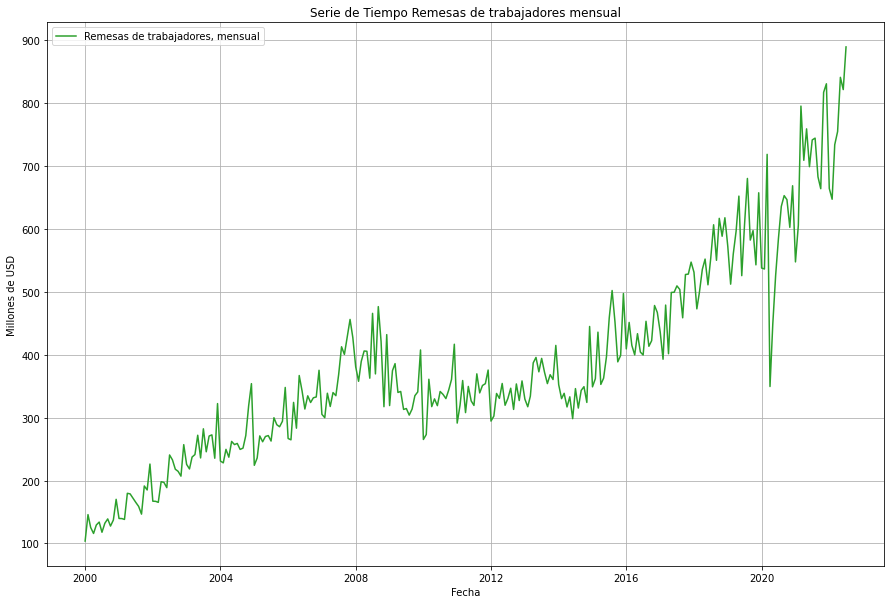

In [6]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(remesas, color='tab:green', label='Remesas de trabajadores, mensual')
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.set_title('Serie de Tiempo Remesas de trabajadores mensual')
ax.grid(True)
ax.legend(loc='upper left');

Al observar el gráfico de la serie lo primero que se evidencia es una tendencia creciente (la cual no parece ser una función suave), también se observa que la serie presenta indicios de varianza marginal no constante (en algunos instantes de tiempo la variabilidad parece ser mayor), por otra parte se concluye que la serie no estacionaria en el sentido débil, debido a que la media difiere a lo largo del tiempo, finalmente la serie parece no tener ciclo estacional, sin embargo más abajo a través de la serie diferenciada se determinará si hay presencia de ciclos ocultos en la serie.

### Estabilización en varianza

Al observar el gráfico de la serie, una de las primeras acciones que estaríamos tentados a hacer es transformar la serie a escala logarítmica, debido a que se manejan unidades en millones de USD y se busca estabilizar la varianza de la serie, Sin embargo para evaluar si es la transformación indicada se hará uso de la metodología basada en transformación de tipo Box-Cox, en la cual se estima un parámetro $\lambda$ a través de cualquiera de las dos formas (loglik y guerrero) en las que está implementada en el software.

+ **Transformación Box-Cox**

In [7]:
import scipy as sp
import scipy.stats 
sp.stats.boxcox(remesas,alpha=0.05) #(0.058, 0.522) #Data must be positive

(array([ 9.76761319, 11.1344932 , 10.51008057, 10.19681686, 10.63722743,
        10.78210855, 10.26142549, 10.72354002, 10.93330437, 10.5831735 ,
        10.87940283, 11.79897059, 10.9550986 , 10.94927701, 10.90979771,
        12.04240013, 12.019185  , 11.84493574, 11.67260959, 11.50008528,
        11.15714431, 12.32601601, 12.1736716 , 13.10733419, 11.72165756,
        11.71543741, 11.67325283, 12.48606965, 12.45977641, 12.26210348,
        13.4065363 , 13.24659283, 12.93100314, 12.85863014, 12.68804634,
        13.7306921 , 13.09632121, 12.94087697, 13.33907647, 13.41930171,
        14.01372878, 13.30996076, 14.2012351 , 13.50837309, 13.99040861,
        14.02445844, 13.30013851, 14.8917562 , 13.20827222, 13.1474622 ,
        13.58475318, 13.33466417, 13.82897646, 13.73312792, 13.7675962 ,
        13.58285802, 13.62353223, 14.0044453 , 14.83397619, 15.39562494,
        13.06509909, 13.309225  , 13.99416495, 13.81909129, 13.97691438,
        14.00392368, 13.84013454, 14.5125496 , 14.3

In [8]:
%%R
library(forecast)
#library(FitAR) # genera error en colab

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [9]:
# -i pasar los datos de entorno python a R (analogamente -o: pasar los datos de entrono R a python)
%R -i remesas

In [10]:
%%R 
forecast::BoxCox.lambda(remesas, method = "guerrero", lower = -1, upper = 3)

[1] 0.08589458


Dado que la estimación de $\lambda$ a través de los dos métodos (loglik y guerreo) lleva a la misma concluisón $\lambda > 0$, la transformación para estabilizar la varianza en este caso es la siguiente:

$$ f_{\lambda}(r_{t}) = \lambda^{-1} (r_{t}^{\lambda}-1)) \quad\text{donde $r_t$: remesas en el tiempo $t$}$$


In [11]:
bc_remesas=sp.stats.boxcox(remesas,lmbda=0.08589458).rename('BC_remesas')
remesas2 = pd.concat([remesas, bc_remesas], axis=1)
remesas2.head()

,remesas,BC_remesas
Fecha,,
2000-01-01,103.751344,5.703735
2000-02-01,145.837278,6.218536
2000-03-01,125.347269,5.987766
2000-04-01,115.880748,5.869252
2000-05-01,129.341871,6.035336


In [12]:
%R -i remesas2

Ahora usamos la misma función para verificar si en verdad la varianza fue estabilizada, en este caso $\lambda$ da un valor cercano a 1 con lo cual se verifica que la tranformación Box-Cox implementada fue la adecuada.

In [13]:
%%R
forecast::BoxCox.lambda(remesas2$BC_remesas, method = "guerrero", lower = -1, upper = 3)

[1] 1.075401


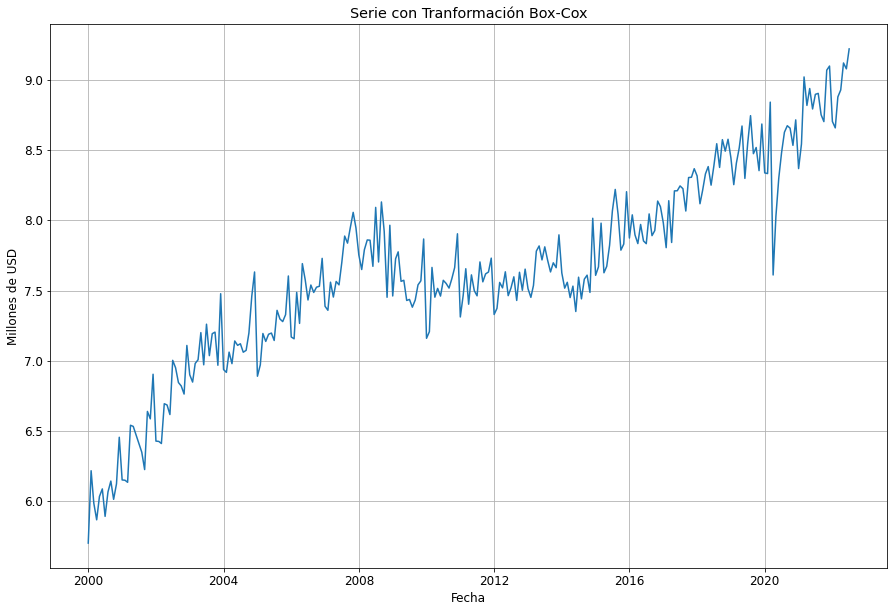

In [14]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

plt.plot(remesas2['BC_remesas'])
plt.title('Serie con Tranformación Box-Cox') 
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.grid(True)
plt.show()

In [15]:
%%R
#install.packages("rlang", version = "1.0.3")
#install.packages("timetk")
library(timetk)
library(lubridate)
library(dplyr)
library(lessR)
library(fpp3)

R[write to console]: 
Attaching package: ‘lubridate’


R[write to console]: The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
lessR 4.2.3                         feedback: gerbing@pdx.edu 
--------------------------------------------------------------
> d <- Read("")   Read text, Excel, SPSS, SAS, or R data file
  d is default data frame, data= in analysis routines optional

Learn about reading, writing, and manipulating data, graphics,
testing means and proportions, regression, factor analysis,
customization, and descriptive statistics from pivot tables.
  Enter:  browseVignettes("lessR")

View changes in this and recent versions of lessR.
  Enter: news(package=

In [16]:
%%R
remesas2$Fecha = rownames(remesas2)
remesas2$Fecha = ymd_hms(remesas2$Fecha)
remesas2$Mes = month(remesas2$Fecha, label = TRUE)

### Suavizamiento de la serie de tiempo

A continuación se implementan algunos métodos para descubrir en la serie de tiempo con transformación Box Cox componentes como tendencia y estacionalidad.

In [17]:
%%R
rms = ts(remesas2$BC_remesas, frequency = 12, start = c(2000, 1))       

In [18]:
%%R
#remesas2_stl <- rms %>%
#  model(stl = STL(rms))
    
#remesas2_stl %>%
#  components() %>%
#  autoplot()

NULL


+ Seasonal-Trend decomposition with LOESS (STL)

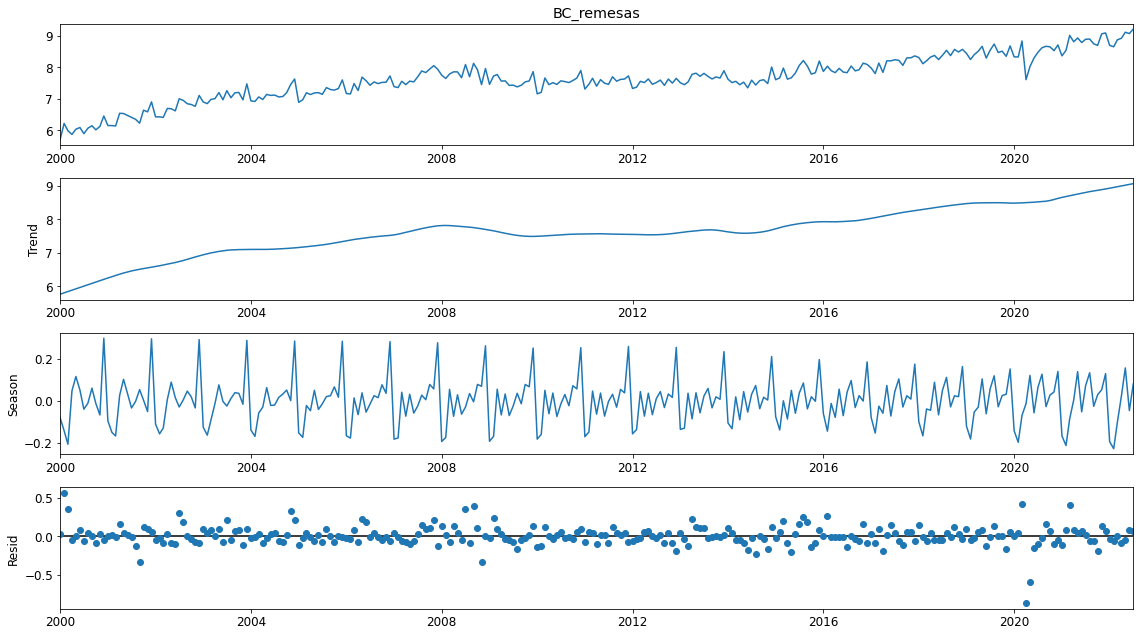

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 9

rms_stl = STL(
remesas2['BC_remesas'],
seasonal=13, # the seasonal smoother and can only take odd integer values greater than or equal to 7
robust=True).fit()

rms_stl.plot()
plt.show()

### Eliminación de la tendencia

A continuación se busca eliminar la tendencia lineal de la serie de Remesas, diferenciando la serie de forma ordinaria una sola vez.

In [20]:
dif_remesas=remesas2['BC_remesas'].diff(periods=1).rename('st_remesas')

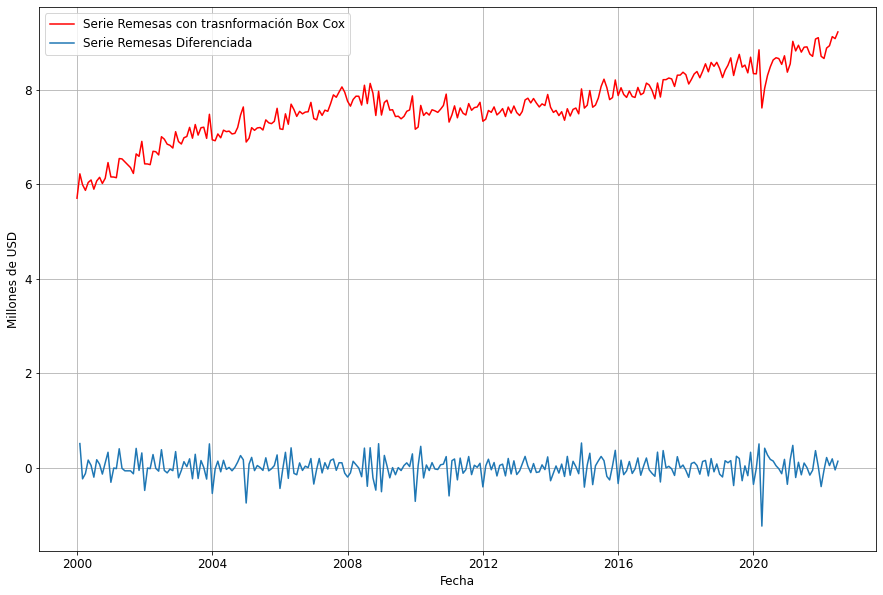

In [21]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(remesas2['BC_remesas'], 'r', label="Serie Remesas con trasnformación Box Cox")
ax.plot(dif_remesas, '-', label="Serie Remesas Diferenciada")
ax.set_xlabel('Fecha')
ax.set_ylabel('Millones de USD')
ax.grid(True)
ax.legend(loc="best");

### Gráficos ACF y PACF

In [22]:
%R -i dif_remesas

In [23]:
%%R
remesas2$dif_remesas = dif_remesas
#dif_rms = ts(na.omit(dif_remesas), frequency = 12, start = c(2000, 2))       

In [24]:
%%R
#remesas2_stl <- remesas2 %>%
#  model(stl = STL(remesas2))
    
#remesas2_stl %>%
#  components() %>%
#  autoplot()

NULL


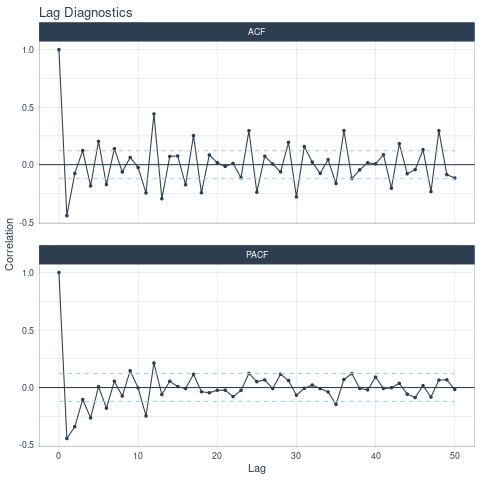

In [25]:
%%R
remesas2%>%timetk::plot_acf_diagnostics(
       Fecha, dif_remesas,               # ACF & PACF
        .lags = 50,          # 7-Days of hourly lags
        .interactive = FALSE)

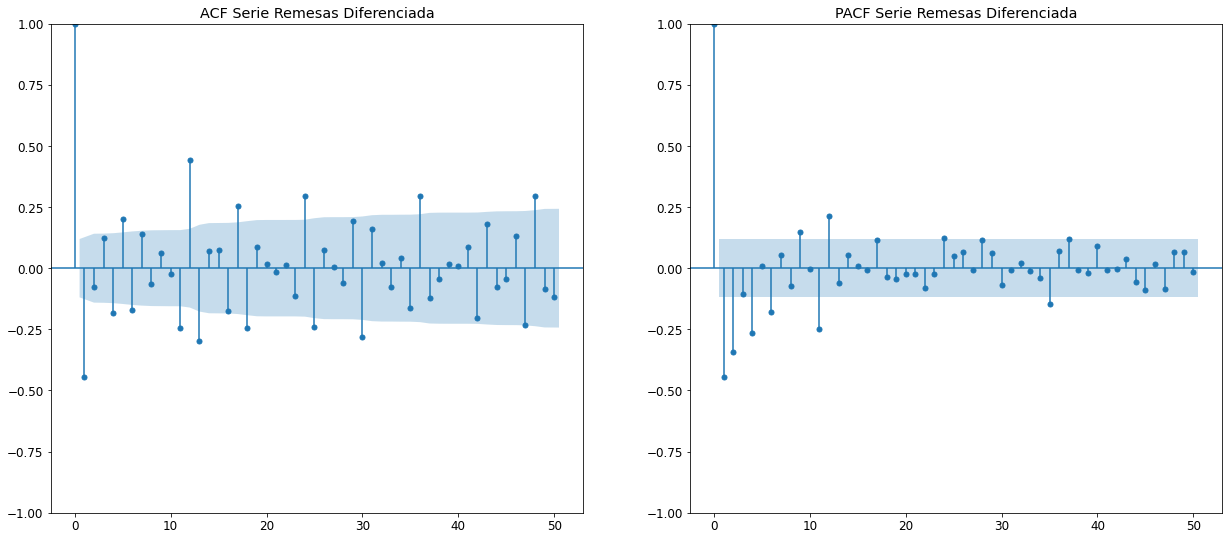

In [26]:
fig, ax = plt.subplots(1,2,figsize=(21,9))
plot_acf(dif_remesas.dropna(),adjusted=False,lags=50,ax=ax[0],title='ACF Serie Remesas Diferenciada')
plot_pacf(dif_remesas.dropna(),lags=50,ax=ax[1],title='PACF Serie Remesas Diferenciada', method='ywmle')
plt.show()

Tanto en el gráfico de la función de autocorrelación (ACF) como en el PACF se evidencia que los rezagos 1 y 12 tienen un valor alto lo que sugiere una fuerte asociación estadística tanto negativa como postiva respectivamente, además se observa que hay rezagos de ordenes grandes para los cuales los valores de la ACF caen por fuera del intervalo de confianza para un modelo MA, sin embargo por el contexto del problema no hace sentido que la remesas de 15,20,25 o 30 meses atrás influencien lo que ocurre con las remesas en el mes actual, se procede a ajustar modelos AR(12) y MA(12) puros.

In [27]:
remesas3 = pd.concat([remesas2, dif_remesas], axis=1)
remesas3 = pd.DataFrame(remesas3['st_remesas']).dropna()
remesas3.head()

,st_remesas
Fecha,
2000-02-01,0.514801
2000-03-01,-0.230770
2000-04-01,-0.118514
2000-05-01,0.166083
2000-06-01,0.053839


## **Creación de variables rezagadas**

In [28]:
df1 = pd.DataFrame()

for i in range(12,0,-1):
    df1[['t-'+str(i)]] = remesas3.shift(i)
    
#df1 = df1.dropna()

In [29]:
# Create column t
df1['t'] = remesas3.values
df1 = df1.dropna()
df1.head()

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
Fecha,,,,,,,,,,,,,
2001-02-01,0.514801,-0.230770,-0.118514,0.166083,0.053839,-0.195324,0.173606,0.077495,-0.129802,0.109965,0.331504,-0.303661,-0.002138
2001-03-01,-0.230770,-0.118514,0.166083,0.053839,-0.195324,0.173606,0.077495,-0.129802,0.109965,0.331504,-0.303661,-0.002138,-0.014513
2001-04-01,-0.118514,0.166083,0.053839,-0.195324,0.173606,0.077495,-0.129802,0.109965,0.331504,-0.303661,-0.002138,-0.014513,0.405709
2001-05-01,0.166083,0.053839,-0.195324,0.173606,0.077495,-0.129802,0.109965,0.331504,-0.303661,-0.002138,-0.014513,0.405709,-0.008103
2001-06-01,0.053839,-0.195324,0.173606,0.077495,-0.129802,0.109965,0.331504,-0.303661,-0.002138,-0.014513,0.405709,-0.008103,-0.061096


+ **Dividir los datos**

In [30]:
### TRAIN TEST SPLIT ###
window_shape = 12
time_h = 1

train = df1.head(200)
test = df1[~df1.index.isin(train.index)]
print(train.shape, test.shape)

(200, 13) (58, 13)


In [31]:
y_train, y_test = train['t'], test['t'] # respuestas
X_train = train[['t-12', 't-11', 't-10', 't-9', 't-8', 't-7','t-6', 't-5', 't-4', 't-3','t-2', 't-1']] ##Regresoras
X_test = test[['t-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1']]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(200, 12) (200,)
(58, 12) (58,)


## Bagging

In [32]:
from sklearn.ensemble import  BaggingRegressor # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
bag_rgr =  BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_rgr.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_samples=100,
                 n_estimators=500, n_jobs=-1)

In [33]:
y_pred = bag_rgr.predict(X_test)
y_pred

array([ 0.08243045, -0.07500026,  0.08593738,  0.10700273, -0.05057586,
        0.19785843, -0.03733713,  0.08704495,  0.05858402, -0.04894486,
        0.05874514, -0.02611034,  0.12423666, -0.09750323,  0.07559869,
        0.15995581, -0.06390244,  0.11778408,  0.02921026,  0.09597566,
       -0.01951602, -0.05534395, -0.07476807, -0.14730475,  0.15756291,
       -0.08778267,  0.11999811, -0.14143732, -0.06836303,  0.12048539,
       -0.21809571,  0.19367958, -0.36995853, -0.08135959,  0.04856275,
       -0.1352847 ,  0.04521109,  0.04188837,  0.1603488 , -0.24413259,
        0.10098267,  0.02594681, -0.49000251,  0.13582229, -0.03515811,
        0.06275013,  0.06715041, -0.04794498,  0.1047561 ,  0.05188962,
       -0.12858971, -0.05159854,  0.04339848,  0.17405221, -0.17777056,
        0.13534946, -0.13810935,  0.05583048])

In [34]:
import sklearn

In [35]:
# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",bag_rgr.score(X_train, y_train))
print("Coeficiente R2 sobre el conjunto de prueba:",bag_rgr.score(X_test,y_test))  # predictions are horrible if negative value, no relationship if 0
print("el RECM es:",(((bag_rgr.predict(X_test)-y_test)**2).sum())**0.5)

Coeficiente R2 sobre el conjunto de entrenamiento: 0.7877204430871676
Coeficiente R2 sobre el conjunto de prueba: 0.18837329216950194
el RECM es: 1.7902665494000036


## block bootstrap

In [36]:
### SMOOTH TRAIN DATA ###

smoother = SpectralSmoother(smooth_fraction=0.18, pad_len=12)
smoother.smooth(train.T)

<tsmoothie.smoother.SpectralSmoother>

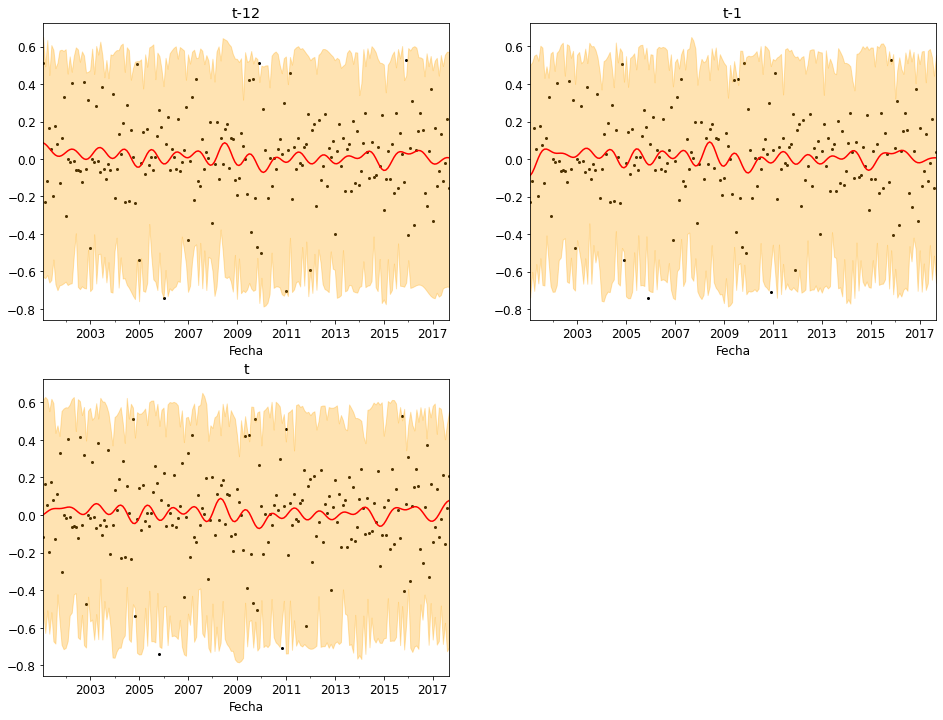

In [37]:
plt.figure(figsize=(16,12))
cols = df1[['t-12', 't-1', 't']]

for i,c in enumerate(cols):
    
    plt.subplot(2,2,i+1)
    
    np.random.seed(33)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, pad_len=12), 
                               bootstrap_type='mbb', block_length=12)
    bts_samples = bts.sample(train[c], n_samples=100)
    
    pd.Series(smoother.smooth_data[i], index=train.index).plot(c='red')
    plt.scatter(train.index, smoother.data[i], c='black', s=4)
    plt.fill_between(train.index, bts_samples.min(0), bts_samples.max(0), alpha=0.3, color='orange')
    plt.title(c)

In [38]:
### BOOSTRAP TRAIN SERIES ###
cols = df1.columns

bts_samples = []

for i,c in enumerate(cols):
    
    np.random.seed(33)
    bts = BootstrappingWrapper(SpectralSmoother(smooth_fraction=0.18, pad_len=12), 
                                                bootstrap_type='mbb', block_length=24)
    bts_samples.append(bts.sample(train[c], n_samples=30))
    
bts_samples = np.stack(bts_samples, axis=-1)
bts_samples.shape

(30, 200, 13)

## Referencias

+ Tsay, R. S., & Chen, R. (2018). Nonlinear time series analysis (Vol. 891). John Wiley & Sons.
+ Géron, A. (2017). Hands-on machine learning with scikit-learn and tensorflow: Concepts. Tools, and Techniques to build intelligent systems.
+ Hyndman, R. J. (2018). George athanasopoulos. Forecasting: Principles and Practice. Monash University, Australia, 2, 23.